In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

In [2]:
# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# define function to compute log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

In [3]:
# lets select a token and use that to predict the price
sample = 'BTC'
tok_tot = pd.read_csv(f'/mnt/intermediate_datasets/{sample}.csv', index_col = 'timestamp')
tok_21 = tok_tot.loc[totimestamp("01/01/2021"):, :]
# remove the last rows where Target was not calculated (as the following 15 minute data was not available)
tok_21 = tok_21[tok_21.Target.notna()]

/usr/local/anaconda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
tok_21.drop('Unnamed: 0', axis = 1).to_csv('BTC_21.csv')

In [4]:
tok_21.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378693 entries, 1609459260 to 1632181440
Data columns (total 10 columns):
Unnamed: 0    378693 non-null int64
Asset_ID      378693 non-null int64
Count         378693 non-null float64
Open          378693 non-null float64
High          378693 non-null float64
Low           378693 non-null float64
Close         378693 non-null float64
Volume        378693 non-null float64
VWAP          378693 non-null float64
Target        378693 non-null float64
dtypes: float64(8), int64(2)
memory usage: 31.8 MB


In [5]:
# select training and test periods
train_window = [totimestamp("01/01/2021"), totimestamp("31/08/2021")]
test_window = [totimestamp("01/09/2021")]

tok_train = tok_21.loc[totimestamp("01/01/2021"):totimestamp("01/09/2021"), :]
tok_test = tok_21.loc[totimestamp("01/09/2021"):, :]

assert tok_train.shape[0] + tok_test.shape[0] == tok_21.shape[0]

## input Data Analysis

Text(0.5, 1.0, 'Volume histogram')

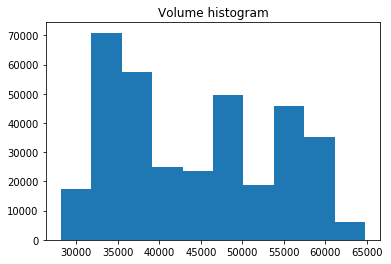

In [5]:
plt.hist(tok_train.VWAP)
plt.title('Volume histogram')

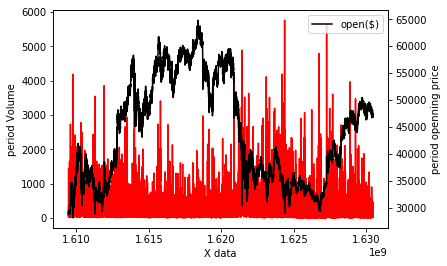

In [45]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(tok_train.Volume, color = 'red', label = 'volume')
ax1.set_xlabel('X data')
ax1.set_ylabel('period Volume')
ax2.plot(tok_train.Open, color = 'black', label = 'open($)')
ax2.set_ylabel('period openning price')
plt.legend()
plt.show()

In [11]:
tok_train['AR1'] = tok_train.Open.diff()

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


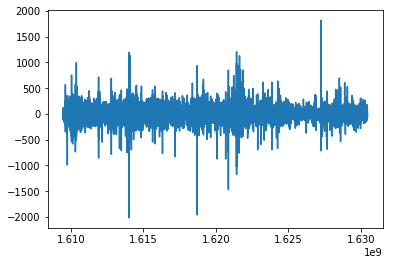

In [12]:
plt.plot(tok_train.AR1)

In [7]:
column_correlations = tok_train.drop(['Unnamed: 0', 'Asset_ID', 'Count'], axis = 1).corr()
column_correlations

,Open,High,Low,Close,Volume,VWAP,Target
Open,1.000000,0.999969,0.999965,0.999983,-0.108889,0.999993,-0.018403
High,0.999969,1.000000,0.999917,0.999971,-0.105042,0.999975,-0.018465
Low,0.999965,0.999917,1.000000,0.999968,-0.113199,0.999972,-0.018358
Close,0.999983,0.999971,0.999968,1.000000,-0.109017,0.999996,-0.018440
Volume,-0.108889,-0.105042,-0.113199,-0.109017,1.000000,-0.109068,-0.007496
VWAP,0.999993,0.999975,0.999972,0.999996,-0.109068,1.000000,-0.018419
Target,-0.018403,-0.018465,-0.018358,-0.018440,-0.007496,-0.018419,1.000000


In [8]:
column_correlations.style.background_gradient(cmap='coolwarm')

,Open,High,Low,Close,Volume,VWAP,Target
Open,1,0.999969,0.999965,0.999983,-0.108889,0.999993,-0.0184026
High,0.999969,1,0.999917,0.999971,-0.105042,0.999975,-0.018465
Low,0.999965,0.999917,1,0.999968,-0.113199,0.999972,-0.0183581
Close,0.999983,0.999971,0.999968,1,-0.109017,0.999996,-0.01844
Volume,-0.108889,-0.105042,-0.113199,-0.109017,1,-0.109068,-0.00749607
VWAP,0.999993,0.999975,0.999972,0.999996,-0.109068,1,-0.0184188
Target,-0.0184026,-0.018465,-0.0183581,-0.01844,-0.00749607,-0.0184188,1


# Auto Correlation Analysis
ACF plot to get an idea on time series data

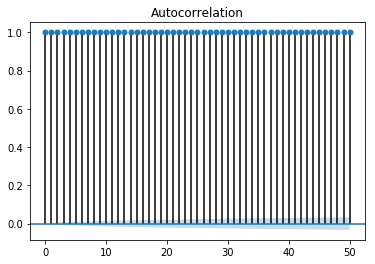

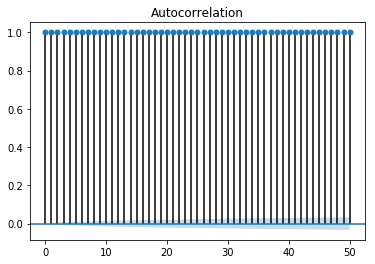

In [46]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(tok_train.Open.squeeze(), lags=50)
#data: your time series
#lags: number of 'periods' you will like to investigate 

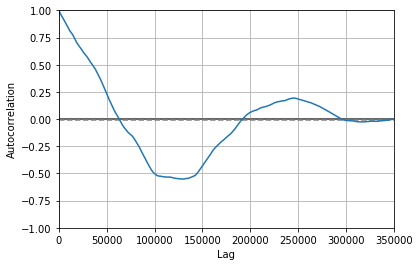

In [12]:
pd.plotting.autocorrelation_plot(tok_train.Open)

## Feature engineering

In [6]:
tok_train.head()

,Unnamed: 0,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,,
1609459260,18935914,1,4039.0,28985.511250,29086.90,28960.0,29032.387500,163.787036,29017.664870,0.000396
1609459320,18935928,1,1969.0,29031.175000,29079.56,28951.5,29002.956734,98.754670,29014.703526,-0.000069
1609459380,18935942,1,1689.0,29002.977509,29069.39,28967.8,29005.580000,55.202131,29003.078663,-0.000137
1609459440,18935956,1,1146.0,29004.293750,29057.73,28971.8,29000.490000,56.575903,29006.256629,-0.000682
1609459500,18935970,1,2088.0,28994.918934,29031.71,28929.3,28962.285818,70.319136,28972.005783,-0.000446


## Arima Model

In [13]:
from statsmodels.tsa.arima_model import ARIMA

In [91]:
train_s = tok_train.Open
arima = ARIMA(train_s, order = (10, 1, 0))
# model = arima.fit()
y_hat = model.forecast(10)[0]
y = tok_test.Open[:10].values

/usr/local/anaconda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [105]:
predicted_y = np.array(list(train_s.values) + list(y_hat))[-50:]
real_y = np.array(list(train_s.values) + list(y))[-50:]

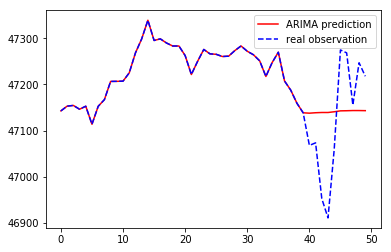

In [114]:
plt.plot(predicted_y, label = 'ARIMA prediction', color = 'red')
plt.plot(real_y, label = 'real observation', color ='blue', linestyle = 'dashed')
plt.legend()

In [21]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observations:               349908
Model:                ARIMA(10, 1, 0)   Log Likelihood            -1914549.663
Method:                       css-mle   S.D. of innovations             57.549
Date:                Mon, 08 Nov 2021   AIC                        3829123.326
Time:                        14:10:25   BIC                        3829252.511
Sample:                             1   HQIC                       3829160.448
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0519      0.098      0.530      0.596      -0.140       0.244
ar.L1.D.Open      0.0709      0.002     41.950      0.000       0.068       0.074
ar.L2.D.Open     -0.0224      0.002    -